In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RepeatedStratifiedKFold
from sklearn import preprocessing
from sklearn.metrics import *

from itertools import product

from sklearn.naive_bayes import GaussianNB

import xgboost as xgb

from sklearn.neural_network import MLPClassifier

import seaborn as sns

In [3]:
def reID(ids, df):
    # Change to universal 'UniProtKB-AC' IDs
    df = pd.merge(ids, df, how='right', left_on=['ID'], right_on=['ID_2'])
    df.drop(columns=['ID_2', 'ID', 'ID_type'], inplace=True)
    df.rename(columns={'UniProtKB-AC': 'Protein_2'}, inplace=True)

    df = pd.merge(ids, df, how='right', left_on=['ID'], right_on=['ID_1'])
    df.drop(columns=['ID_1', 'ID', 'ID_type'], inplace=True)
    df.rename(columns={'UniProtKB-AC': 'Protein_1'}, inplace=True)

    return df

In [4]:
def remove_duplicates(data):
    # Reorder the protein IDs to be alphabetical
    mask = data['Protein_1'] > data['Protein_2']
    data.loc[mask, ['Protein_1', 'Protein_2']] = data.loc[mask, ['Protein_2', 'Protein_1']].values

    # Remove duplicate entries
    data = data.groupby(['Protein_1', 'Protein_2'], as_index=False).mean()
    return data

# Data Preparation

## Data Download

In [5]:
# ID 'translations' for S. cerevisiae
ids = pd.read_csv('Data/YEAST_559292_idmapping.dat', delimiter='\t', names=['UniProtKB-AC', 'ID_type', 'ID'])
ids.drop_duplicates('ID', inplace=True)
ids

,UniProtKB-AC,ID_type,ID
0,P38903,UniProtKB-ID,2A5D_YEAST
1,P38903,Gene_Name,RTS1
2,P38903,Gene_Synonym,SCS1
3,P38903,Gene_OrderedLocusName,YOR014W
4,P38903,Gene_ORFName,OR26.04
...,...,...,...
295411,E9PAE7,UniRef100,UniRef100_E9PAE7
295412,E9PAE7,UniRef90,UniRef90_E9PAE7
295414,E9PAE7,UniParc,UPI000006B44A
295416,E9PAE7,EMBL-CDS,CAA88575.1


In [6]:
# Gene interaction score for ExE genes from The Cell Map
ExE_gi_score = pd.read_csv('Data/TheCellMap/SGA_ExE.txt', delimiter='\t')
ExN_gi_score = pd.read_csv('Data/TheCellMap/SGA_ExN_NxE.txt', delimiter='\t')
NxN_gi_score = pd.read_csv('Data/TheCellMap/SGA_NxN.txt', delimiter='\t')
all_gi_score = pd.concat([ExE_gi_score, ExN_gi_score, NxN_gi_score])

gi_score = pd.DataFrame()
gi_score['ID_1'] = all_gi_score['Array Strain ID'].str[:7]
gi_score['ID_2'] = all_gi_score['Query Strain ID'].str[:7]
gi_score['GI score'] = all_gi_score['Genetic interaction score (ε)']

# Convert to UniProtID
gi_score = reID(ids, gi_score)
gi_score.dropna(inplace=True)

# Remove duplicate entries
gi_score = remove_duplicates(gi_score)

gi_score

,Protein_1,Protein_2,GI score
0,A0A023PXB5,A2P2R3,0.03990
1,A0A023PXB5,D6W196,0.00930
2,A0A023PXB5,O13297,-0.00350
3,A0A023PXB5,O13516,0.01230
4,A0A023PXB5,O13539,0.00480
...,...,...,...
11857625,Q99393,Q99395,0.00310
11857626,Q99393,Q9URQ3,0.00100
11857627,Q99394,Q99395,-0.00035
11857628,Q99394,Q9URQ3,-0.00960


In [7]:
# Gene interaction profile similarity score for ExE genes from The Cell Map
gi_profile = pd.read_csv('Data/TheCellMap/cc_ALL.txt', delimiter='\t', skiprows=1)
gi_profile.drop(columns=['Unnamed: 0'], inplace=True)
gi_profile.rename(columns={'Unnamed: 1': 'ID'}, inplace=True)
gi_profile.set_index('ID', inplace=True)

# Stack dataframe
gi_profile = gi_profile.stack().reset_index()
gi_profile.columns = ['ID_1', 'ID_2', 'GI profile similarity']

# Convert to UniProtID
gi_profile = reID(ids, gi_profile)
gi_profile.dropna(inplace=True)

# Remove duplicate entries
gi_profile = remove_duplicates(gi_profile)

gi_profile

,Protein_1,Protein_2,GI profile similarity
0,A0A023PXB5,A0A023PXB9,-0.01210
1,A0A023PXB5,A0A023PXH6,0.02093
2,A0A023PXB5,A0A023PXH9,0.06894
3,A0A023PXB5,A0A023PXI0,-0.05596
4,A0A023PXB5,A0A023PXI4,0.04399
...,...,...,...
14617789,Q99395,Q9URQ3,0.02018
14617790,Q9P305,Q9URQ3,-0.01318
14617791,Q9URQ3,Q9URQ3,0.00262
14617792,Q9URQ3,Q9URQ5,0.03798


In [8]:
# Co-expression data
co_expr = pd.read_csv('Data/2010.Hughes00.flt.knn.avg.pcl', delimiter='\t')
gids = co_expr.iloc[1:,0]
co_expr = co_expr.iloc[1:, 3:].T.corr()
co_expr.index = list(gids)
co_expr.columns = list(gids)

# Stack dataframe
co_expr = co_expr.stack().reset_index()
co_expr.columns = ['ID_1', 'ID_2', 'Co-expression correlation']

# Convert to UniProtID
co_expr = reID(ids, co_expr)
co_expr.dropna(inplace=True)

# Reorder the protein IDs to be alphabetical
mask = co_expr['Protein_1'] > co_expr['Protein_2']
co_expr.loc[mask, ['Protein_1', 'Protein_2']] = co_expr.loc[mask, ['Protein_2', 'Protein_1']].values

# Remove duplicate entries
co_expr = co_expr.groupby(['Protein_1', 'Protein_2'], as_index=False).mean()

co_expr

,Protein_1,Protein_2,Co-expression correlation
0,A0A023PXB5,A0A023PXB5,1.000000
1,A0A023PXB5,A0A023PXB9,-0.040971
2,A0A023PXB5,A0A023PXG7,-0.230390
3,A0A023PXB5,A0A023PXH2,0.151840
4,A0A023PXB5,A0A023PXH6,-0.025946
...,...,...,...
18809906,Q99401,Q9URQ3,-0.059373
18809907,Q99401,Q9URQ5,0.248646
18809908,Q9URQ3,Q9URQ3,1.000000
18809909,Q9URQ3,Q9URQ5,-0.041482


In [9]:
# Structural interaction data
struct_interact = pd.read_csv('Data/structural_interactome.txt', delimiter='\t')
struct_interact = struct_interact.loc[:, ['Protein_1', 'Protein_2']]
struct_interact['Structural interaction'] = [1]*struct_interact.shape[0]

# Remove duplicate entries
struct_interact = remove_duplicates(struct_interact)

struct_interact

,Protein_1,Protein_2,Structural interaction
0,O13297,O13297,1.0
1,O13297,Q01159,1.0
2,O14455,P39517,1.0
3,O60200,P35200,1.0
4,O60200,Q04006,1.0
...,...,...,...
2648,Q6WNK7,Q6WNK7,1.0
2649,Q92328,Q92328,1.0
2650,Q92331,Q92331,1.0
2651,Q99210,Q99210,1.0


In [10]:
# Experimental PPI data
ppi_df = pd.read_csv("Data/BIOGRID-MV-Physical-4.4.229.mitab.txt", delimiter='\t')

ppi_df = ppi_df[ppi_df['Taxid Interactor A']=='taxid:559292']
ppi_df = ppi_df[ppi_df['Taxid Interactor B']=='taxid:559292']

ppi = pd.DataFrame()
ppi['ID_1'] = ppi_df['#ID Interactor A'].str.rsplit(':', n=1, expand=True).iloc[:, 1]
ppi['ID_2'] = ppi_df['ID Interactor B'].str.rsplit(':', n=1, expand=True).iloc[:, 1]
ppi['Experimental PPI'] = [1]*ppi.shape[0]

# Convert to UniProtID
ppi = reID(ids, ppi)
ppi.dropna(inplace=True)

# Remove duplicate entries
ppi = remove_duplicates(ppi)

ppi

,Protein_1,Protein_2,Experimental PPI
0,D6VTK4,D6VTK4,1.0
1,D6VTK4,P01149,1.0
2,D6VTK4,P08539,1.0
3,D6VTK4,P18851,1.0
4,D6VTK4,P38853,1.0
...,...,...,...
25111,Q99257,Q99383,1.0
25112,Q99271,Q99271,1.0
25113,Q99287,Q99287,1.0
25114,Q99288,Q99288,1.0


In [11]:
# Co-complex data
cocomplex = pd.read_csv('Data/559292.tsv', sep='\t')

def split_values(row):
    values = row['Identifiers (and stoichiometry) of molecules in complex'].split('|')
    new_rows = []
    for i in range(len(values)):
        for j in range(i + 1, len(values)):
            new_row = {'column1': values[i].split('(')[0], 'column2': values[j].split('(')[0]}
            new_rows.append(new_row)
    return pd.DataFrame(new_rows)

cocomplex = pd.concat([split_values(row) for _, row in cocomplex.iterrows()], ignore_index=True)
cocomplex.columns = ['Protein_1', 'Protein_2']

# Reorder the protein IDs to be alphabetical
mask = cocomplex['Protein_1'] > cocomplex['Protein_2']
cocomplex.loc[mask, ['Protein_1', 'Protein_2']] = cocomplex.loc[mask, ['Protein_2', 'Protein_1']].values
cocomplex['Co-complex'] = [1]*cocomplex.shape[0]

cocomplex = cocomplex.drop_duplicates()
cocomplex

,Protein_1,Protein_2,Co-complex
0,P32797,P38960,1
1,P32797,Q07921,1
2,P38960,Q07921,1
3,P22336,P26754,1
4,P22336,P26755,1
...,...,...,...
13823,P17214,Q06163,1
13824,P17214,URS0000348061_559292,1
13825,Q03096,Q06163,1
13826,Q03096,URS0000348061_559292,1


In [12]:
# Co-pathway data
copathway_data = pd.read_csv('Data/pathbank_primary_proteins.csv')
pathways = set(copathway_data['Pathway Name'])
copathway = pd.DataFrame(columns=['Protein_1', 'Protein_2'])

for path in pathways:
    data = copathway_data[copathway_data['Pathway Name'] == path].dropna(subset=['Uniprot ID'])
    combos = list(product(data['Uniprot ID'], repeat=2))
    sorted_combos = [tuple(sorted(comb)) for comb in combos if comb[0]!=comb[1]]
    unique_combos = pd.DataFrame(data=list(set(sorted_combos)), columns=['Protein_1', 'Protein_2'])
    copathway = pd.concat([copathway, unique_combos])


copathway['Co-pathway'] = [1]*copathway.shape[0]

copathway = copathway.drop_duplicates()
copathway

,Protein_1,Protein_2,Co-pathway
0,P27796,Unknown,1
0,P07395,P0AEQ6,1
1,P0AAE1,Q6LDM2,1
2,A0A0A8RMC9,P04805,1
3,P21629,Q02SF5,1
...,...,...,...
73,Q02979,Q12674,1
74,P05374,P20485,1
75,P05375,P20485,1
76,P17898,P32660,1


In [13]:
# SimGIC scores
simGIC = pd.read_csv('Data/gosim_cz/mf_fastsemsim_output_refPPIs_mf_SimGIC', delimiter='	')
simGIC.columns = ['Protein_1', 'Protein_2', 'SimGIC']

# Remove duplicate entries
simGIC = remove_duplicates(simGIC)

simGIC

,Protein_1,Protein_2,SimGIC
0,O13297,O14455,0.031133
1,O13297,O60200,0.023536
2,O13297,O74700,0.025416
3,O13297,O94742,0.033566
4,O13297,P00044,0.025419
...,...,...,...
1380286,Q99380,Q99394,0.207688
1380287,Q99380,Q9URQ5,0.113002
1380288,Q99383,Q99394,0.162891
1380289,Q99383,Q9URQ5,0.098294


## Integration

In [14]:
# GI score and GI profile
df = pd.merge(gi_score, gi_profile, on=['Protein_1', 'Protein_2'], how='inner')

# Co-expression data
df = pd.merge(df, co_expr, how='inner', on=['Protein_1','Protein_2'])

# Structural interaction
df = pd.merge(df, struct_interact, how='left', on=['Protein_1','Protein_2'])
df['Structural interaction'] = df['Structural interaction'].fillna(0)

# Experimental PPIs
df = pd.merge(df, ppi, how='left', on=['Protein_1','Protein_2'])
df['Experimental PPI'] = df['Experimental PPI'].fillna(0)

# Co-complex
df = pd.merge(df, cocomplex, how='left', on=['Protein_1','Protein_2'])
df['Co-complex'] = df['Co-complex'].fillna(0)

# Co-pathway
df = pd.merge(df, copathway, how='left', on=['Protein_1','Protein_2'])
df['Co-pathway'] = df['Co-pathway'].fillna(0)

# SimGIC
df = pd.merge(df, simGIC, how='inner', on=['Protein_1','Protein_2'])
df

,Protein_1,Protein_2,GI score,GI profile similarity,Co-expression correlation,Structural interaction,Experimental PPI,Co-complex,Co-pathway,SimGIC
0,O13297,P00044,-0.01385,-0.007018,-0.002322,0.0,0.0,0.0,0.0,0.025419
1,O13297,P00128,-0.03710,0.034857,0.023362,0.0,0.0,0.0,0.0,0.009947
2,O13297,P00330,0.00090,-0.051760,-0.001173,0.0,0.0,0.0,0.0,0.021906
3,O13297,P00359,-0.01290,-0.004954,-0.003179,0.0,0.0,0.0,0.0,0.013773
4,O13297,P00360,-0.01260,0.070137,-0.131360,0.0,0.0,0.0,0.0,0.014298
...,...,...,...,...,...,...,...,...,...,...
854208,Q99278,Q99383,-0.00875,0.017310,-0.007144,0.0,0.0,0.0,0.0,0.027012
854209,Q99278,Q99394,-0.05470,-0.040640,0.338437,0.0,0.0,0.0,0.0,0.031366
854210,Q99344,Q99380,0.07550,-0.052027,0.051033,0.0,0.0,0.0,0.0,0.021702
854211,Q99344,Q99394,-0.02390,-0.008210,-0.274396,0.0,0.0,0.0,0.0,0.023661


## Get E-values for all protein pairs

In [16]:
# Get E values for protein sequence pairwise alignments
from Bio import Entrez
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
import subprocess

Entrez.email = "livtoft09@gmail.com"

def seq_file(id):
    # Get sequence for protein id
    handle = Entrez.efetch(db="protein", id=id, rettype="fasta", retmode="text")
    record = SeqIO.read(handle, "fasta")
    seq = str(record.seq)

    # Create FASTA file for protein seq1
    seq = SeqRecord(Seq(seq),
                   id=id)
    SeqIO.write(seq, 'Sequences/'+id+'.fasta', "fasta")


def get_e_val(id1, id2):
    seq1 = 'Sequences/'+id1+'.fasta'
    seq2 = 'Sequences/'+id2+'.fasta'

    # Run BLAST using subprocess
    command = ['blastp', '-query', seq1, '-subject', seq2, '-outfmt', '6']
    try:
        result = subprocess.run(command, capture_output=True, text=True, check=True)
        if len(result.stdout) == 0:
            return np.nan
        else:
            return float(result.stdout.strip().split('\t')[10])
        
    except subprocess.CalledProcessError as e:
        print(f"Error running BLAST: {e}")
        return None

In [81]:
ids = list(set(list(df['Protein_1']) + list(df['Protein_2'])))

for id in ids:
    seq_file(id)

In [82]:
# Get E value for the alignment each protein sequence pair
e_vals = pd.DataFrame(columns=['Protein_1', 'Protein_2', 'E value'])
e_vals['Protein_1'] = df['Protein_1']
e_vals['Protein_2'] = df['Protein_2']

for index, row in e_vals.iterrows():
    row['E value'] = get_e_val(row['Protein_1'], row['Protein_2'])

    if index % 10000 == 0:
        print(index/e_vals.shape[0], '% done')

e_vals.to_csv('Data/e_vals.csv')

0.0 % done
0.011706682057051344 % done
0.023413364114102688 % done
0.03512004617115403 % done
0.046826728228205376 % done
0.05853341028525672 % done
0.07024009234230806 % done
0.0819467743993594 % done
0.09365345645641075 % done
0.1053601385134621 % done
0.11706682057051344 % done
0.1287735026275648 % done
0.14048018468461612 % done
0.15218686674166748 % done
0.1638935487987188 % done
0.17560023085577017 % done
0.1873069129128215 % done
0.19901359496987286 % done
0.2107202770269242 % done
0.22242695908397556 % done
0.2341336411410269 % done
0.24584032319807822 % done
0.2575470052551296 % done
0.2692536873121809 % done
0.28096036936923224 % done
0.29266705142628363 % done
0.30437373348333496 % done
0.3160804155403863 % done
0.3277870975974376 % done
0.33949377965448896 % done
0.35120046171154035 % done
0.3629071437685917 % done
0.374613825825643 % done
0.38632050788269434 % done
0.39802718993974573 % done
0.40973387199679706 % done
0.4214405540538484 % done
0.4331472361108997 % done
0.4

##

In [15]:
e_vals = pd.read_csv('Data/e_vals.csv')

# Set E value for pairs with insiginifcant alignment to 100
e_vals.fillna(100, inplace=True)

# Set all values = 0 to 10^-200
e_vals.loc[e_vals['E value'] == 0.0, 'E value'] = 1e-200

# Take log(E-value)
e_vals['log(E-value)'] = np.log(e_vals['E value'])
e_vals.drop(columns=['E value'], inplace=True)


df = pd.merge(df, e_vals, on=['Protein_1', 'Protein_2'], how='inner')
df.index = df['Protein_1'] + ',' + df['Protein_2']
df.drop(columns=['Protein_1', 'Protein_2'], inplace=True)
df

,GI score,GI profile similarity,Co-expression correlation,Structural interaction,Experimental PPI,Co-complex,Co-pathway,SimGIC,Unnamed: 0,log(E-value)
"O13297,P00044",-0.01385,-0.007018,-0.002322,0.0,0.0,0.0,0.0,0.025419,0,0.095310
"O13297,P00128",-0.03710,0.034857,0.023362,0.0,0.0,0.0,0.0,0.009947,1,-0.597837
"O13297,P00330",0.00090,-0.051760,-0.001173,0.0,0.0,0.0,0.0,0.021906,2,-1.108663
"O13297,P00359",-0.01290,-0.004954,-0.003179,0.0,0.0,0.0,0.0,0.013773,3,0.641854
"O13297,P00360",-0.01260,0.070137,-0.131360,0.0,0.0,0.0,0.0,0.014298,4,0.788457
...,...,...,...,...,...,...,...,...,...,...
"Q99278,Q99383",-0.00875,0.017310,-0.007144,0.0,0.0,0.0,0.0,0.027012,854208,4.605170
"Q99278,Q99394",-0.05470,-0.040640,0.338437,0.0,0.0,0.0,0.0,0.031366,854209,0.405465
"Q99344,Q99380",0.07550,-0.052027,0.051033,0.0,0.0,0.0,0.0,0.021702,854210,4.605170
"Q99344,Q99394",-0.02390,-0.008210,-0.274396,0.0,0.0,0.0,0.0,0.023661,854211,-0.248461


In [16]:
has_data = df[(df['Structural interaction'] == 1.0) | (df['Experimental PPI'] == 1.0) | (df['Co-complex'] == 1.0) | (df['Co-pathway'] == 1.0)]
print(has_data.shape[0], 'Have a structural interaction, PPI, are co-complex, or are co-pathway')

no_data = df[~df.index.isin(list(has_data.index))]
print(no_data.shape[0], 'have NO structural interaction, are not PPI, are not co-complex, or are not co-pathway')

print('\nRandomly selecting', has_data.shape[0], 'entries that have 0.0 for all features')
data = no_data.sample(n=has_data.shape[0], replace=False)
data = pd.concat([data, has_data])

6729 Have a structural interaction, PPI, are co-complex, or are co-pathway
847484 have NO structural interaction, are not PPI, are not co-complex, or are not co-pathway

Randomly selecting 6729 entries that have 0.0 for all features


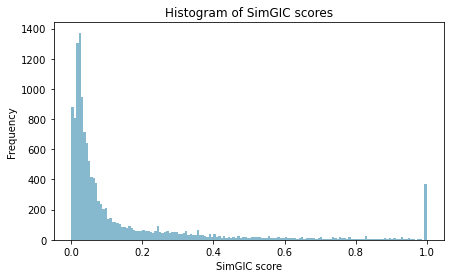

In [16]:
# Plot histogram of SimGIC scores
plt.figure(figsize=(7, 4))
plt.hist(data['SimGIC'], bins=150, color='#86b8ce')
#plt.axvline(0.175, color='#eb2b41', linewidth=1)
plt.title('Histogram of SimGIC scores')
plt.xlabel('SimGIC score')
plt.ylabel('Frequency')
plt.show()

In [17]:
# Function to calculate correlation coefficient between two arrays
def corr(x, y, **kwargs):
    
    # Calculate the value
    coef = np.corrcoef(x, y)[0][1]
    # Make the label
    label = 'corr = ' + str(round(coef, 2))
    
    # Add the label to the plot
    ax = plt.gca()
    ax.annotate(label, xy=(0.2, 0.5), size = 15, xycoords=ax.transAxes)

g = sns.pairplot(df, kind='scatter', corner=True, palette="magma")
g.map_lower(corr)
plt.show()

NameError: name 'd' is not defined

In [17]:
x = data.iloc[:, data.columns != 'SimGIC']
y = pd.DataFrame(data['SimGIC'])

# Scale features
scaler = preprocessing.StandardScaler()
x = pd.DataFrame(columns=x.columns, index=x.index, data=scaler.fit_transform(x))

# Split into train and test datasets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [18]:
def similar(feat, target, Tu, Tl):
    target.loc[target['SimGIC']>=Tu, 'Similar'] = 1
    target.loc[target['SimGIC']<Tl, 'Similar'] = 0
    target.drop(columns=['SimGIC'], inplace=True)
    target.dropna(inplace=True)

    feat = feat.loc[target.index, :]
    feat.dropna(inplace=True)
    
    return feat, target


x_train_small, y_train_small = similar(x_train.copy(), y_train.copy(), 0.3, 0.015)
x_train_full, y_train_full = similar(x_train.copy(), y_train.copy(), 0.175, 0.175)
x_test_full, y_test_full = similar(x_test.copy(), y_test.copy(), 0.175, 0.175)

# Split training data into 10-folds
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
y_train_small.value_counts()

Similar
0.0        1516
1.0        1510
dtype: int64

# Model Training

In [19]:
# Define function for binary model performance evaluation
def performance(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    # Accuracy
    performance = [accuracy_score(y_true, y_pred)]
    # Sensitivity
    performance = performance + [tp/(tp+fn)]
    # Specificity
    performance = performance + [tn/(fp+tn)]
    # PPV
    performance = performance + [tp/(tp+fp)]
    # NPV
    performance = performance + [tn/(tn+fn)]
    # False positive rate
    performance = performance + [fp/(fp+tn)]
    # False negative rate
    performance = performance + [fn/(fn+tp)]
    # AUC-ROC
    performance = performance + [roc_auc_score(y_true, y_pred)]
    
    return performance

In [20]:
def evaluate_model(train_func, x_train, y_train, x_test, y_test, params, kfold):
  x = pd.concat([x_train, x_test])
  y = pd.concat([y_train, y_test])

  x_reindex = x.reset_index(drop=True)
  y_reindex = y.reset_index(drop=True)

  # Create dataframes to store metrics
  train_performance = pd.DataFrame(index=[i+1 for i in range(0,10)], columns=['accuracy', 'sensitivity', 'specificity', 'PPV', 'NPV', 'FPR', 'FNR', 'AUC-ROC'])
  train_performance.iloc[:, :] = 0

  test_performance = pd.DataFrame(index=[i+1 for i in range(0,10)], columns=['accuracy', 'sensitivity', 'specificity', 'PPV', 'NPV', 'FPR', 'FNR', 'AUC-ROC'])
  test_performance.iloc[:, :] = 0

  # Enumerate through each fold
  for i, (train_index,test_index) in enumerate(kfold.split(x, y)):
    x_train_fold = x_reindex.iloc[train_index, :]
    y_train_fold = y_reindex.iloc[train_index, :]
    x_test_fold = x_reindex.iloc[test_index, :]
    y_test_fold = y_reindex.iloc[test_index, :]
  
    # Get train and test performance metrics for current fold
    train_metrics, test_metrics = train_func(x_train_fold, y_train_fold, x_test_fold, y_test_fold, params)

    train_performance.iloc[i, :] = train_metrics
    test_performance.iloc[i, :] = test_metrics
  
    
  return train_performance, test_performance

## Naïve Bayes

In [21]:
def train_NB(x_train_fold, y_train_fold, x_test_fold, y_test_fold, params):
    gnb = GaussianNB()
    train_pred = gnb.fit(x_train_fold, y_train_fold.values.ravel()).predict(x_train_fold)
    train_metrics = performance(y_train_fold, train_pred)
    
    test_pred = gnb.predict(x_test_fold)
    test_metrics = performance(y_test_fold, test_pred)
    
    return train_metrics, test_metrics

[1756  348  260  328]


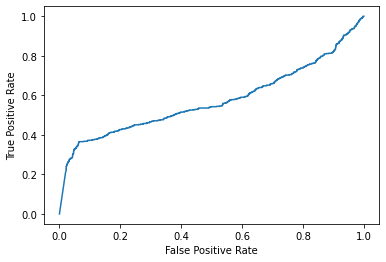

In [22]:
gnb = GaussianNB()
y_pred = gnb.fit(x_train_small, y_train_small.values.ravel()).predict(x_test_full)
#tn, fp, fn, tp
print(confusion_matrix(y_test_full, y_pred).ravel())

y_prob = [max(p) for p in gnb.predict_proba(x_test_full)]
fpr, tpr, _ = roc_curve(y_test_full, y_prob)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()


In [23]:
NB_train_metrics, NB_test_metrics = evaluate_model(train_NB, x_train_full, y_train_full, x_test_full, y_test_full, {}, kfold)
NB_test_metrics['model'] = 'NB'

In [25]:
NB_train_metrics.iloc[:,:].sum()/10

accuracy       0.784738
sensitivity    0.396475
specificity    0.895876
PPV             0.52153
NPV            0.838339
FPR            0.104124
FNR            0.603525
AUC-ROC        0.646176
dtype: object

In [27]:
NB_test_metrics.iloc[:,:-1].sum()/10

accuracy       0.784737
sensitivity    0.396297
specificity    0.895917
PPV            0.521197
NPV            0.838435
FPR            0.104083
FNR            0.603703
AUC-ROC        0.646107
dtype: object

## XGBoost

In [23]:
def tune_xgb_params(x_train, y_train, x_test, y_test, kfold):
    xgb_params = {'n_estimators' : list(np.arange(10, 110, 10)),
                'max_depth' : list(np.arange(1, 5, 1)),
                'learning_rate' : [0.01, 0.04, 0.08, 0.1, 0.12, 0.22, 0.24],
                'reg_lambda': [2,3,4]}


    # Calculate class weight (scale_pos_weight) = sum(negative intances) / sum(positive instances)
    weight = len(y_train[y_train['Similar'] == 0]) / len(y_train[y_train['Similar'] == 1])

    # Instantiate XGB model
    xgb_model = xgb.XGBClassifier(booster='gbtree', scale_pos_weight=weight, eval_metric='map')

    # Conduct search of best parameters with 10-fold cross validation
    xgb_search = GridSearchCV(xgb_model,
                      param_grid=xgb_params,
                      cv=kfold,
                      return_train_score=True
                      )

    # Fit the model
    xgb_search.fit(x_train, y_train, eval_set=[(x_test, y_test)], verbose=False)

    best_xgb_params = xgb_search.best_params_
    return best_xgb_params

In [24]:
# function to train XGB with best hyperparameters and compute each performance metric
def train_xgb(x_train, y_train, x_test, y_test, params):
    weight = len(y_train[y_train['Similar'] == 0]) / len(y_train[y_train['Similar'] == 1])

    xgb_model = xgb.XGBClassifier(learning_rate=params['learning_rate'],
                                   max_depth=params['max_depth'],
                                   n_estimators=params['n_estimators'],
                                   reg_lambda=params['reg_lambda'],
                                   scale_pos_weight=weight,
                                   eval_metric='map')

    fit_xgb = xgb_model.fit(x_train, y_train, verbose=0)
    
    train_pred = fit_xgb.predict(x_train)
    train_metrics = performance(y_train, train_pred)

    test_pred = fit_xgb.predict(x_test)
    test_metrics = performance(y_test, test_pred)

    return train_metrics, test_metrics

[1595  523  186  388]


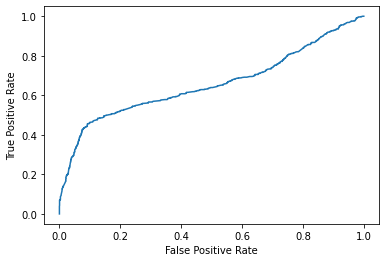

In [160]:
weight = len(y_train_small[y_train_small['Similar'] == 0]) / len(y_train_small[y_train_small['Similar'] == 1])

xgb_model = xgb.XGBClassifier(learning_rate=0.22,
                                   max_depth=4,
                                   n_estimators=20,
                                   reg_lambda=4,
                                   scale_pos_weight=weight,
                                   eval_metric='map')

fit_xgb = xgb_model.fit(x_train_small, y_train_small, verbose=0)
    
y_pred = fit_xgb.predict(x_test_full)
#tn, fp, fn, tp
print(confusion_matrix(y_test_full, y_pred).ravel())

y_prob = [max(p) for p in fit_xgb.predict_proba(x_test_full)]
fpr, tpr, _ = roc_curve(y_test_full, y_prob)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()


In [25]:
#xgb_params = tune_xgb_params(x_train_small, y_train_small, x_test_full, y_test_full, kfold)
xgb_params={'learning_rate': 0.12, 'max_depth': 4, 'n_estimators': 80, 'reg_lambda': 3}
XGB_train_metrics, XGB_test_metrics = evaluate_model(train_xgb, x_train_full, y_train_full, x_test_full, y_test_full, xgb_params, kfold)
XGB_test_metrics['model'] = 'XGB'
xgb_params

{'learning_rate': 0.12, 'max_depth': 4, 'n_estimators': 80, 'reg_lambda': 3}

In [ ]:
XGB_test_metrics.iloc[:,:-1].sum()/10

accuracy       0.787098
sensitivity    0.725349
specificity    0.847277
PPV            0.822282
NPV            0.760222
FPR            0.152723
FNR            0.274651
AUC-ROC        0.786313
dtype: object

In [26]:
XGB_test_metrics.iloc[:,:-1].sum()/10

accuracy       0.751227
sensitivity    0.658001
specificity    0.777938
PPV            0.459421
NPV            0.888171
FPR            0.222062
FNR            0.341999
AUC-ROC        0.717969
dtype: object

# Multi-Layer Perceptron

In [120]:
def tune_mlp_params(x_train, y_train, kfold):
    no_nodes =  [5, 10, 20, 60]
    hidden_layer_sizes = no_nodes + [(i,j) for i in no_nodes for j in no_nodes] + [(i,j,k) for i in no_nodes for j in no_nodes for k in no_nodes]

    mlp_params = {'hidden_layer_sizes': hidden_layer_sizes,
                  'activation': ['identity', 'logistic', 'tanh', 'relu'],
                  'alpha' : [0.000001, 0.000005, 0.00001, 0.00005],
    }

    # Instantiate MLP model
    mlp_model = MLPClassifier(random_state=42)

    # Conduct search of best parameters with 10-fold cross validation
    mlp_search = GridSearchCV(mlp_model,
                      param_grid=mlp_params,
                      cv=kfold,
                      return_train_score=True
                      )

    # Fit the model
    mlp_search.fit(x_train, y_train.values.ravel())

    best_mlp_params = mlp_search.best_params_
    return best_mlp_params

In [29]:
# function to train MLP with best hyperparameters and compute each performance metric
def train_mlp(x_train, y_train, x_test, y_test, params):

    mlp_model = MLPClassifier(hidden_layer_sizes=params['hidden_layer_sizes'],
                              activation=params['activation'],
                              alpha=params['alpha'])

    fit_mlp = mlp_model.fit(x_train, y_train.values.ravel())
    
    train_pred = fit_mlp.predict(x_train)
    train_metrics = performance(y_train, train_pred)

    test_pred = fit_mlp.predict(x_test)
    test_metrics = performance(y_test, test_pred)

    return train_metrics, test_metrics

/Users/livtoft/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1118: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1532  572  191  397]


/Users/livtoft/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


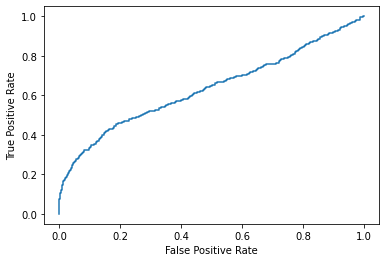

In [30]:
mlp_model = MLPClassifier(hidden_layer_sizes=(20,60),
                              activation='relu',
                              alpha=5e-6)

fit_mlp = mlp_model.fit(x_train_small, y_train_small)
    
y_pred = fit_mlp.predict(x_test_full)
print(confusion_matrix(y_test_full, y_pred).ravel())

y_prob = [max(p) for p in fit_mlp.predict_proba(x_test_full)]
fpr, tpr, _ = roc_curve(y_test_full, y_prob)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

In [31]:
#mlp_params = tune_mlp_params(x_train_small, y_train_small, kfold)
mlp_params = {'activation': 'relu',
'alpha': 5e-06,
'hidden_layer_sizes': (20, 60)}

MLP_train_metrics, MLP_test_metrics = evaluate_model(train_mlp, x_train_full, y_train_full, x_test_full, y_test_full, mlp_params, kfold)
MLP_test_metrics['model'] = 'MLP'
mlp_params

/Users/livtoft/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/livtoft/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/livtoft/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/livtoft/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/livtoft/o

{'activation': 'relu', 'alpha': 5e-06, 'hidden_layer_sizes': (20, 60)}

In [32]:
MLP_train_metrics.iloc[:,:].sum()/10

accuracy       0.827405
sensitivity    0.357264
specificity    0.961983
PPV             0.73133
NPV            0.839531
FPR            0.038017
FNR            0.642736
AUC-ROC        0.659623
dtype: object

In [33]:
MLP_test_metrics.iloc[:,:-1].sum()/10

accuracy        0.80584
sensitivity    0.313152
specificity     0.94686
PPV            0.627961
NPV             0.82818
FPR             0.05314
FNR            0.686848
AUC-ROC        0.630006
dtype: object